# Problem 1

In [154]:
import numpy as np
import matplotlib.pyplot as pl
from scipy.spatial import KDTree
import time, timeit

In [4]:
rng = np.random.default_rng(66727)

In [155]:
def gen_catalog(n, size=100, dims=3, rng=rng):
    '''
    Generate a catlog of 'n' points in 'dims' dimensions distributed uniformly at random

    n: number of samples
    size: side length of cubical box
    dims: dimensions of cube
    rng: numpy random number generator object
    '''
    return rng.random((n,dims))*size


def sq_dist(x1,x2):
    return np.sum((x1-x2)**2)

def dist(x1, x2):
    return sq_dist(x1,x2)**0.5

def sep(x1,x2):
    return (x1-x2) / np.sqrt(sq_dist(x1,x2))

def soft_grav(x1, x2, m = 1, eta = 1):
    return -m / (sq_dist(x1,x2) + eta**2) * sep(x1,x2)

def brute_acc(cat, f, eta=1):
    acc = np.zeros(cat.shape)

    for i in range(len(cat)):
        for j in range(len(cat)):
            if i<=j:
                continue
            a = f(cat[i], cat[j], eta=eta)
            acc[i] -= a
            acc[j] += a
    
    return acc


def coms(node, cat, dic, node_idx=0):
    if isinstance(node, KDTree.leafnode):
        com = np.average(cat[node.idx], axis=0)
        dic[node_idx] = com

    else:
        coms(node.less, cat, dic, node_idx*2+1)
        coms(node.greater, cat, dic, node_idx*2+2)
        dic[node_idx] = (dic[node_idx*2+1] * node.less.children + dic[node_idx*2+2] * node.greater.children) /\
                        (node.less.children + node.greater.children)



def traverse(i, cat, node, coms, node_idx=0, depth=0, size=100, f=soft_grav, tol=1.5):
    a = 0
    if isinstance(node, KDTree.leafnode):
        for j in node.idx:
            if j != i:
                a += f(cat[j], cat[i])
        return a

    d = dist(cat[i], coms[node_idx])
    s = size / 2**(depth/3)
    
    if s/d < tol:
        return f(coms[node_idx], cat[i], m=node.children)

    a += traverse(i, cat, node.less, coms, node_idx=node_idx*2+1, depth=depth+1, f=f, tol=tol)
    a += traverse(i, cat, node.greater, coms, node_idx=node_idx*2+2, depth=depth+1, f=f, tol=tol)

    return a

def tree_acc(cat, f):
    tree = KDTree(cat)
    dic = {}
    coms(tree.tree, cat, dic)
    acc = np.zeros(cat.shape)

    for i in range(len(cat)):
        acc[i] = traverse(i, cat, tree.tree, dic, tol=0.5, f=f)

    return acc

In [162]:
brute_times = []
tree_times = []
avg_err = []

ns = [100,200,400,800,1600,3600]

for n in ns:
    dat = gen_catalog(int(n))

    bstart = time.perf_counter()
    b = brute_acc(dat, soft_grav)
    brute_times.append(time.perf_counter()-bstart)

    print(f"Finished brute force on {n} particles.")

    treestart = time.perf_counter()
    t = tree_acc(dat, soft_grav)
    tree_times.append(time.perf_counter()-treestart)

    print(f"Finished KDTree on {n} particles.")

    avg_err.append(np.mean(np.abs(t-b)/b))

Finished brute force on 100 particles.
Finished KDTree on 100 particles.
Finished brute force on 200 particles.
Finished KDTree on 200 particles.
Finished brute force on 400 particles.
Finished KDTree on 400 particles.
Finished brute force on 800 particles.
Finished KDTree on 800 particles.
Finished brute force on 1600 particles.
Finished KDTree on 1600 particles.
Finished brute force on 3600 particles.
Finished KDTree on 3600 particles.


In [180]:
bfit = np.polyfit(np.log(ns), np.log(brute_times), deg=1)
tfit = np.polyfit(np.log(ns), np.log(tree_times), deg=1)
print(f"Brute Force algorithm is scaling as N^{bfit[0]}")
print(f"KDTree algorithm is scaling as N^{tfit[0]}")

Brute Force algorithm is scaling as N^1.8474592673611998
KDTree algorithm is scaling as N^1.3260460672874466


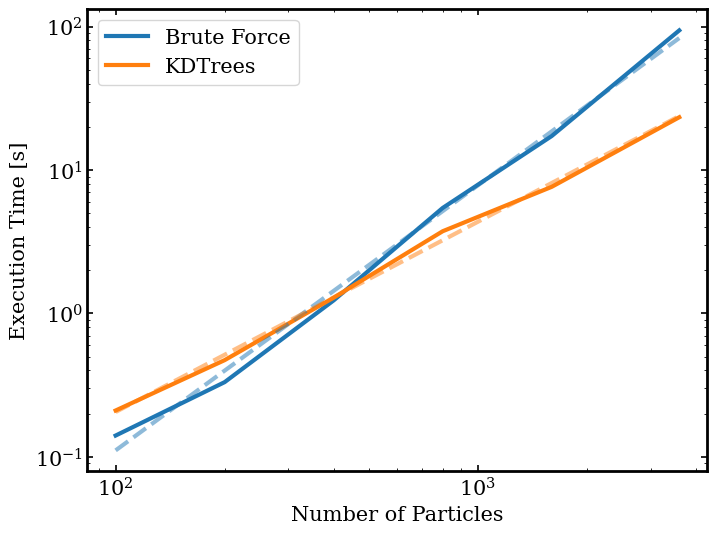

In [172]:
pl.figure(figsize=(8,6))
pl.loglog(ns, brute_times, label="Brute Force")
pl.loglog(ns, tree_times, label="KDTrees")

pl.plot(ns, np.exp(bfit[1])*ns**bfit[0],c="C0",ls="--",alpha=0.5)
pl.plot(ns, np.exp(tfit[1])*ns**tfit[0],c="C1",ls="--",alpha=0.5)

pl.ylabel("Execution Time [s]")
pl.xlabel("Number of Particles")

pl.legend()
pl.show()

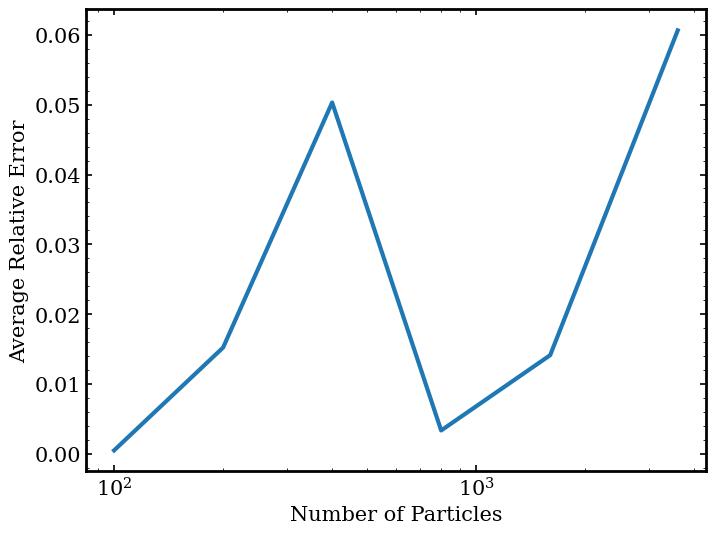

In [181]:
pl.figure(figsize=(8,6))
pl.semilogx(ns, np.abs(avg_err))

pl.ylabel("Average Relative Error")
pl.xlabel("Number of Particles")

pl.show()

# Problem 2

In [187]:
from pyro import Pyro

In [196]:
solver = "compressible"
problem_name = "kh"
param_file = "inputs.kh"
pyro_sim1 = Pyro(solver)
pyro_sim1.initialize_problem(problem_name, inputs_file=param_file)
pyro_sim1.run_sim()

In [197]:
solver = "compressible_rk"
problem_name = "kh"
param_file = "inputs.kh"
pyro_sim2 = Pyro(solver)
pyro_sim2.initialize_problem(problem_name, inputs_file=param_file)
pyro_sim2.run_sim()

In [198]:
solver = "compressible_fv4"
problem_name = "kh"
param_file = "inputs.kh"
pyro_sim3 = Pyro(solver)
pyro_sim3.initialize_problem(problem_name, inputs_file=param_file)
pyro_sim3.run_sim()

In [199]:
solver = "compressible_sdc"
problem_name = "kh"
param_file = "inputs.kh"
pyro_sim4 = Pyro(solver)
pyro_sim4.initialize_problem(problem_name, inputs_file=param_file)
pyro_sim4.run_sim()

warning, key: compressible.limiter not defined


In [204]:
solver = "compressible"
problem_name = "kh"
param_file = "inputs.kh"
extra_parameters = {'kh.u_1':5, 'kh.u_1':-5}
pyro_sim5 = Pyro(solver)
pyro_sim5.initialize_problem(problem_name, inputs_file=param_file, inputs_dict=extra_parameters)
pyro_sim5.run_sim()

In [205]:
solver = "compressible_rk"
problem_name = "kh"
param_file = "inputs.kh"
extra_parameters = {'kh.u_1':5, 'kh.u_1':-5}
pyro_sim6 = Pyro(solver)
pyro_sim6.initialize_problem(problem_name, inputs_file=param_file, inputs_dict=extra_parameters)
pyro_sim6.run_sim()

In [206]:
solver = "compressible_fv4"
problem_name = "kh"
param_file = "inputs.kh"
extra_parameters = {'kh.u_1':5, 'kh.u_1':-5}
pyro_sim7 = Pyro(solver)
pyro_sim7.initialize_problem(problem_name, inputs_file=param_file, inputs_dict=extra_parameters)
pyro_sim7.run_sim()

In [207]:
solver = "compressible_sdc"
problem_name = "kh"
param_file = "inputs.kh"
extra_parameters = {'kh.u_1':5, 'kh.u_1':-5}
pyro_sim8 = Pyro(solver)
pyro_sim8.initialize_problem(problem_name, inputs_file=param_file, inputs_dict=extra_parameters)
pyro_sim8.run_sim()

warning, key: compressible.limiter not defined


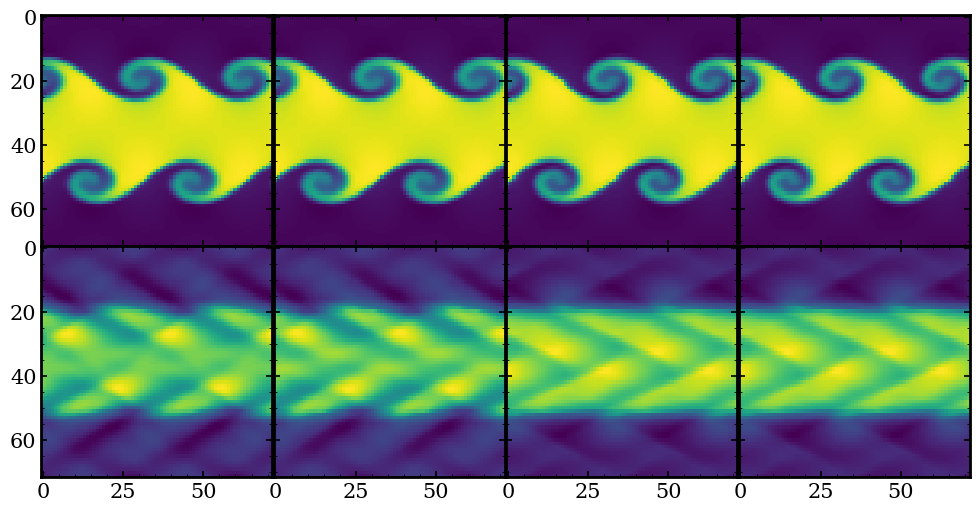

In [234]:
fig, ax = pl.subplots(2,4, figsize=(12,6), sharex=True, sharey=True, gridspec_kw = {'wspace':0, 'hspace':0})

ax[0,0].imshow(pyro_sim1.get_var("density").T)
ax[0,1].imshow(pyro_sim2.get_var("density").T)
ax[0,2].imshow(pyro_sim3.get_var("density").T)
ax[0,3].imshow(pyro_sim4.get_var("density").T)
ax[1,0].imshow(pyro_sim5.get_var("density").T)
ax[1,1].imshow(pyro_sim6.get_var("density").T)
ax[1,2].imshow(pyro_sim7.get_var("density").T)
ax[1,3].imshow(pyro_sim8.get_var("density").T)
pl.show()